In [1]:
import scipy.io
import numpy as np
import matplotlib.pylab as plt
from keras.utils import to_categorical
import cv2

Using TensorFlow backend.


# Load models

In [2]:
from keras.models import *
from keras.layers import *
import warnings
warnings.filterwarnings("ignore")

In [3]:
#load detector
detector = load_model('digit_detector.h5')
#load recognizer
recognizer = load_model('digit_recognizer.h5')

# Define useful functions

In [4]:
def crop(img,bbox,size):
    #crop regions using bboxes and resize them to 32,32
    x = bbox[0]
    y = bbox[1]
    w = bbox[2]
    h = bbox[3]
    region = img[y:y+h,x:x+w]
    return cv2.resize(region,size)

def get_regions(img,bboxes,size=(32,32)):
    regions = []
    for b in bboxes:
        r = crop(img,b,size)
        regions.append(r)
    return np.array(regions)

In [5]:
def NMS(boxes, probs,regions,overlap_threshold=0.1):
    """
    Parameters:
        boxes (ndarray of shape (N, 4))
        probs (ndarray of shape (N,))
        overlap_threshold (float)
    
    Reference: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    """
    if len(boxes) == 0:
        return [],[]
    
    boxes = np.array(boxes, dtype="float")
 
    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    w = boxes[:, 2]
    h = boxes[:, 3]
    x2 = x1+w
    y2 = y1+h
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(probs)
    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value to the list of
        # picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        
        # find the largest (x, y) coordinates for the start of the bounding box and the
        # smallest (x, y) coordinates for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

    
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
    
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        
        # delete all indexes from the index list that have overlap greater than the
        # provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_threshold)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int"),probs[pick],regions[pick]

In [6]:
def draw(img,boxes, digits):
    #draw bboxes on the image
    for b,d in zip(boxes,digits):
        x=b[0]
        y=b[1]
        w=b[2]
        h=b[3]
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)
        cv2.putText(img,str(d),(int(x+w/4),int(y+h/4)),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),1,cv2.LINE_AA)
    return img

In [7]:
def Spot_digit(img, detector, recogizer, p_thres = 0.7):
    vis = img.copy()
    #grayscale
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    #get bounding boxes from MSER algorithm and resize them to (32,32)
    mser = cv2.MSER_create(_delta = 1)
    _, bboxes = mser.detectRegions(img)
    regions = get_regions(img,bboxes) #MSER regions(X,32,32)

    #check if this bounding boxes is a digit using pretrained CNN, using threshold and probability.
    probs = detector.predict_proba(np.expand_dims(regions,axis=3))[:,1]

    msk = probs>=p_thres
    
    if bboxes[msk].size !=0:
        #perform Non-Maximum Suppression
        bboxes,probs,regions = NMS(bboxes[msk],probs[msk],regions[msk])

        #send regions to recognizer, and get the number.
        digits = recognizer.predict(np.expand_dims(regions,axis=3)).argmax(axis=1) + 1
        #change 10 to 0
        digits[digits==10] = 0
        
        #draw result on the image
        vis = draw(vis,bboxes,digits)
        return vis,bboxes,digits
    #visualize the result image
    #plt.imshow(vis[:,:,::-1])
    return vis,None, None

# Evalutation

To test different images, just change the image path in cv2.imread

[3 2]


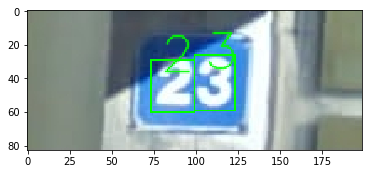

In [8]:
img = cv2.imread('full-image/train/2.png')

show, bboxes, digits = Spot_digit(img,detector,recognizer)

print(digits)
plt.imshow(show[:,:,::-1])

# Load video

This part of the code takes a video as input and gives an output video with bounding boxes and recognized digits.

In [30]:
cap = cv2.VideoCapture('OFS\off-street.mp4')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('OFS\output.avi',fourcc, 20.0, (480,848))

while(cap.isOpened()):
    ret, frame = cap.read()
    if frame is None:
        break
    #print(frame.shape)
    vis, bboxes, digits = Spot_digit(frame, detector, recognizer)
    out.write(vis)
    #print(vis.shape)
    #cv2.imshow('frame',vis)
    #if cv2.waitKey(1) & 0xFF == ord('q'):
    #    break
cap.release()
out.release()
cv2.destroyAllWindows()